In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load datasets

In [29]:
import librosa as lb

import os
from mylib.Regular import Regular
from scipy.fftpack import fft
import warnings
warnings.filterwarnings('ignore')

In [ ]:
for i, path in enumerate(['./dataset/health_f500_txt_2000/',
                           './dataset/health_f1000_txt_2000/', 
                           './dataset/ill_txt_arrythmia/', 
                           './dataset/ill_txt_ischemia/',
                           './dataset/covid19_txt/']):
    print(path)
    dirs = os.listdir(path)
    data = []

    for d in dirs:
        try:
            val = np.loadtxt(path + d)
            X = 0.38*val[:, 0]-0.07*val[:, 1]-0.13*val[:, 6]+0.05*val[:, 7]-0.01*val[:, 8]+0.14*val[:, 9]+0.06*val[:, 10]+0.54*val[:,11]
            if i!=0: X = lb.resample(X, 1000, 500)
          
            X_r = Regular(X, tresh=0.7, ratio=0.2, frequency=500)
            for j in range(len(X_r)):
                if X_r[-1-j] != 0: break
            
            data.append(X_r[:len(X_r)-j])

        except:
            print('ERROR')
            print(val)

    np.save('data%d.npy'%(i+1), data)

# Denosing with FFT

In [2]:
data1 = np.load('data1.npy', allow_pickle=True)
data2 = np.load('data2.npy', allow_pickle=True)
data3 = np.load('data3.npy', allow_pickle=True)
data4 = np.load('data4.npy', allow_pickle=True)
data5 = np.load('data5.npy', allow_pickle=True)

In [3]:
from scipy.fftpack import fft

def denoising(data, thre1=2000, thre2=55000, thre3=10000):
    data_new = []
    noise = []
    
    for i in range(len(data)):
        try:
            sig_fft = fft(data[i])
            if (abs(data[i])>thre1).any() or (abs(sig_fft[:30]).real>thre2).any() or (abs(sig_fft[30:300]).real>thre3).any():
                noise.append(data[i])
            else:
                data_new.append(data[i])
        except:
            print('ERROR')
            continue

    for i in range(len(data_new)):
        plt.plot(data_new[i])        
    plt.show()

    for i in range(len(data_new)):
        plt.plot(fft(data_new[i]).real)        # fft频谱信息
    plt.show()

    for i in range(len(noise)):
        plt.plot(noise[i])
    plt.show()

    for i in range(len(noise)):
        plt.plot(fft(noise[i]).real)        # fft频谱信息
    plt.show()

    return data_new, noise

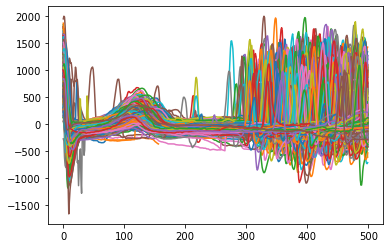

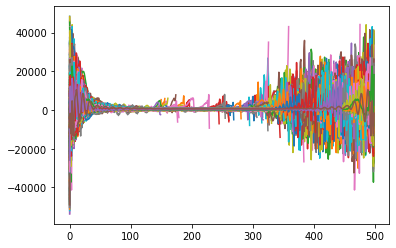

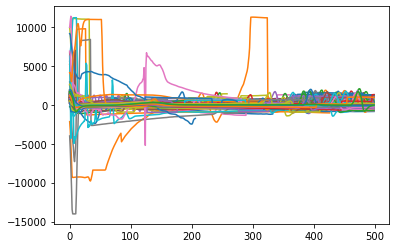

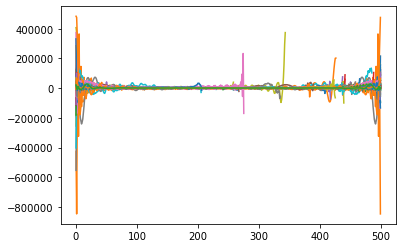

223


In [4]:
# data1_new, noise = denoising(data1, thre1=2000, thre2=55000, thre3=30000)
data1_new, noise = denoising(data1)
print(len(noise))

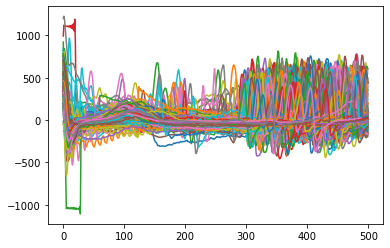

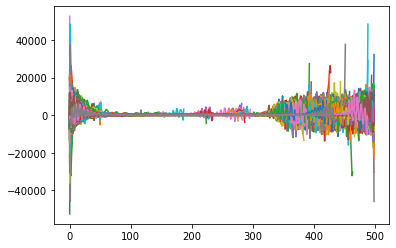

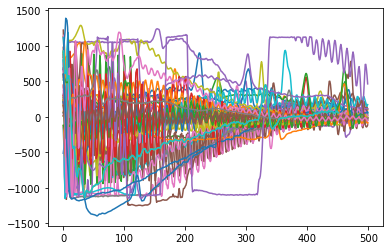

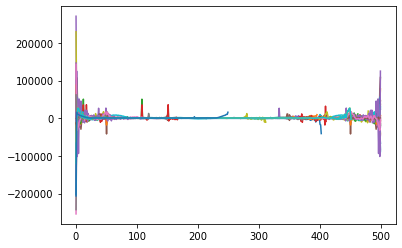

51


In [5]:
# data2_new, noise = denoising(data2, thre1=2000, thre2=55000, thre3=5000)
data2_new, noise = denoising(data2)
print(len(noise))

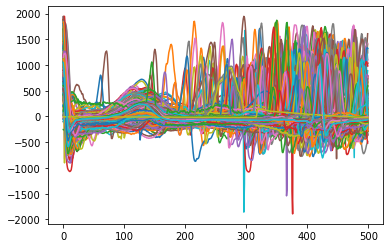

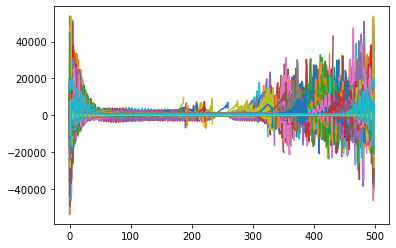

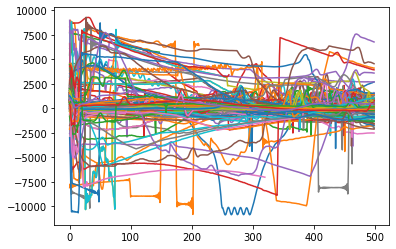

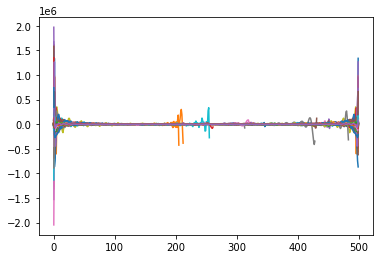

315


In [6]:
# data3_new, noise = denoising(data3, thre1=2000, thre2=80000, thre3=30000)
data3_new, noise = denoising(data3)
print(len(noise))

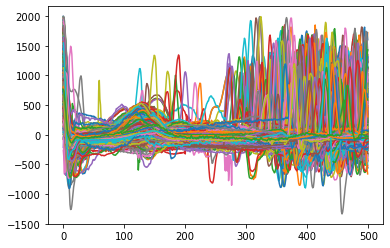

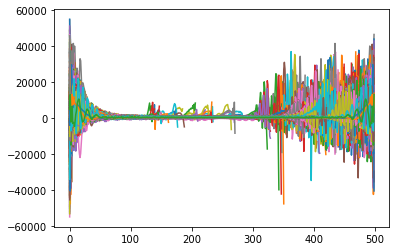

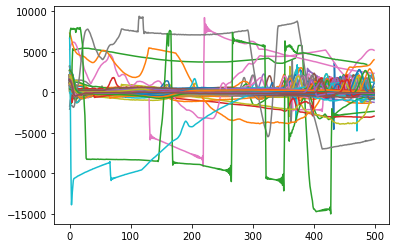

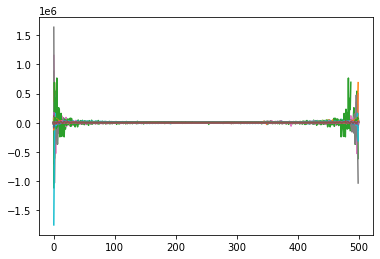

236


In [7]:
# data4_new, noise = denoising(data4, thre1=2000, thre2=100000, thre3=30000)
data4_new, noise = denoising(data4)
print(len(noise))

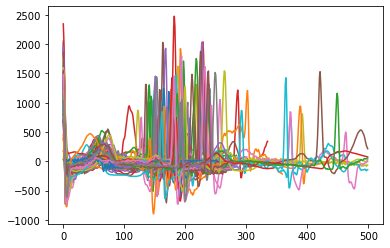

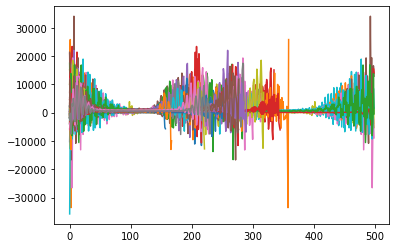

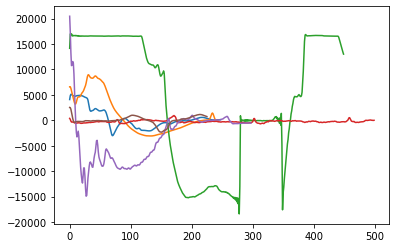

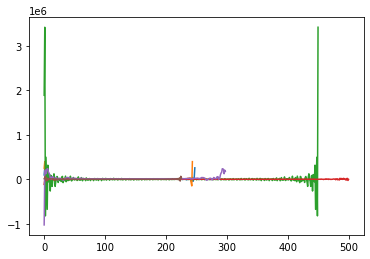

In [8]:
data5_new, noise = denoising(data5, thre1=5000, thre2=100000,thre3=30000)

In [9]:
np.save('data1_dn.npy', data1_new)
np.save('data2_dn.npy', data2_new)
np.save('data3_dn.npy', data3_new)
np.save('data4_dn.npy', data4_new)
np.save('data5_dn.npy', data5_new)

d:\program files\python3\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


# Slice into a single cycle

In [10]:
data1_new = np.load('data1_dn.npy', allow_pickle=True)
data2_new = np.load('data2_dn.npy', allow_pickle=True)
data3_new = np.load('data3_dn.npy', allow_pickle=True)
data4_new = np.load('data4_dn.npy', allow_pickle=True)
data5_new = np.load('data5_dn.npy', allow_pickle=True)

In [11]:
import math

def detect_beat(dd):
    data_new = []
    data_uu = []

    for i in range(len(dd)):
        hrw = 0.5 # One-sided window size, as proportion of the sampling frequency
        fs = 10

        mov_avg = pd.DataFrame(dd[i]).rolling(int(hrw*fs)).mean()[0].values #Calculate moving average
        #Impute where moving average function returns NaN, which is the beginning of the signal where x hrw
        avg_hr = (np.mean(dd[i]))
        q3_hr = pd.DataFrame(dd
        [i]).quantile(.975)[0]
        mov_avg = [avg_hr if pd.isna(x) else x for x in mov_avg]
        mov_avg = [x*1.2 for x in mov_avg]  
        hart_rollingmean = mov_avg
        
        #Mark regions of interest
        window = []
        peaklist = []
        listpos = 0 #We use a counter to move over the different data columns

        for datapoint in dd[i]:
            rollingmean = hart_rollingmean[listpos] #Get local mean
            if (datapoint <= rollingmean) and (len(window) < 1): #If no detectable R-complex activity -> do nothing
                listpos += 1
            elif (datapoint > rollingmean): #If signal comes above local mean, mark ROI
                window.append(datapoint)
                listpos += 1
            else: #If signal drops below local mean -> determine highest point
                maximum = max(window)
                beatposition = listpos - len(window) + (window.index(max(window))) #Notate the position of the point on the X-axis
                if maximum > q3_hr:
                    peaklist.append(beatposition) #Add detected peak to list
                    window = [] #Clear marked ROI
                listpos += 1
        
        ybeat = [dd[i][x] for x in peaklist] #Get the y-value of all peaks for plotting purposes

        if peaklist==[] or len(peaklist)>3:
#             plt.figure(figsize=(6,1))
#             plt.title("Detected peaks in signal")
#             plt.plot(dd[i], alpha=0.5, color='blue') #Plot semi-transparent HR
#             # plt.plot(mov_avg, color ='green') #Plot moving average
#             plt.scatter(peaklist, ybeat, color='red') #Plot detected peaks
#             plt.show()
#             data_uu.append(dd[i])
            pass
        elif len(peaklist)==1:
            if 500-len(dd[i]) > 0:
                p2 = np.zeros(500-len(dd[i]))
                data_new.append(np.concatenate([dd[i], p2]))
            else:
                data_new.append(np.array(dd[i][:500]))
        else:
            p1 = dd[i][peaklist[0]:peaklist[1]]
            if 500-len(p1) > 0:
                p2 = np.zeros(500-len(p1))
                data_new.append(np.concatenate([p1, p2]))
            else:
                data_new.append(np.array(p1[:500]))            
    
    # plt.title("Detected peaks in signal")
    # plt.plot(data_new[-1], alpha=0.5, color='blue') #Plot semi-transparent HR
    # plt.scatter(peaklist, ybeat, color='red') #Plot detected peaks
    # plt.show()

    return np.stack(data_new), data_uu

In [12]:
data1_new, data1_uu = detect_beat(data1_new)

In [13]:
data2_new, data2_uu = detect_beat(data2_new)

In [14]:
data3_new, data3_uu = detect_beat(data3_new)

In [15]:
data4_new, data4_uu = detect_beat(data4_new)

In [16]:
data5_new, data5_uu = detect_beat(data5_new)

In [17]:
np.save('data1_new.npy', data1_new)
np.save('data2_new.npy', data2_new)
np.save('data3_new.npy', data3_new)
np.save('data4_new.npy', data4_new)
np.save('data5_new.npy', data5_new)

In [18]:
#save
data1_all = np.concatenate([data1_new, np.full((data1_new.shape[0], 1), 0)], axis=1)
data2_all = np.concatenate([data2_new, np.full((data2_new.shape[0], 1), 0)], axis=1)
data3_all = np.concatenate([data3_new, np.full((data3_new.shape[0], 1), 1)], axis=1)
data4_all = np.concatenate([data4_new, np.full((data4_new.shape[0], 1), 2)], axis=1)
# data5_all = np.concatenate([data5_st, np.full((data5_st.shape[0], 1), 3)], axis=1)

# data = np.concatenate([data1_all, data2_all, data3_all, data4_all, data5_all])
data = np.concatenate([data1_all, data3_all, data4_all])
np.save('data_all.npy', data)

# Normalization

In [85]:
# data1_new = np.load('data1_new.npy')
# data2_new = np.load('data2_new.npy')
# data3_new = np.load('data3_new.npy')
# data4_new = np.load('data4_new.npy')
# # data5_new = np.load('data5_new.npy')

In [84]:
# from sklearn.preprocessing import MinMaxScaler

# ss = MinMaxScaler(feature_range=(0,1))   # Min-max normalize
# # data_st = ss.fit_transform(np.concatenate([data1_new, data2_new, data3_new, data4_new, data5_new]))
# data_st = ss.fit_transform(np.concatenate([data1_new, data3_new, data4_new]))

# data1_st = data_st[:data1_new.shape[0], :]
# data3_st = data_st[data1_new.shape[0]:data1_new.shape[0] + data3_new.shape[0], :]
# data4_st = data_st[data1_new.shape[0] + data3_new.shape[0]:, :]
# # data5_st = data_st[data1_new.shape[0] + data2_new.shape[0] + data3_new.shape[0] + data4_new.shape[0]:, :]

In [103]:
# from sklearn.preprocessing import MinMaxScaler

# ss = MinMaxScaler(feature_range=(0,1))   # Min-max normalize
# # data_st = ss.fit_transform(np.concatenate([data1_new, data2_new, data3_new, data4_new, data5_new]))
# data_st = ss.fit_transform(np.concatenate([data1_new, data2_new, data3_new, data4_new]))

# data1_st = data_st[:data1_new.shape[0], :]
# data2_st = data_st[data1_new.shape[0]:data1_new.shape[0] + data2_new.shape[0], :]
# data3_st = data_st[data1_new.shape[0] + data2_new.shape[0]:data1_new.shape[0] + data2_new.shape[0] + data3_new.shape[0], :]
# data4_st = data_st[data1_new.shape[0] + data2_new.shape[0] + data3_new.shape[0]:data1_new.shape[0] + data2_new.shape[0] + data3_new.shape[0] + data4_new.shape[0], :]
# # data5_st = data_st[data1_new.shape[0] + data2_new.shape[0] + data3_new.shape[0] + data4_new.shape[0]:, :]

In [14]:
# data1_all = np.concatenate([data1_st, np.full((data1_st.shape[0], 1), 0)], axis=1)
# # data2_all = np.concatenate([data2_st, np.full((data2_st.shape[0], 1), 0)], axis=1)
# data3_all = np.concatenate([data3_st, np.full((data3_st.shape[0], 1), 1)], axis=1)
# data4_all = np.concatenate([data4_st, np.full((data4_st.shape[0], 1), 2)], axis=1)
# # data5_all = np.concatenate([data5_st, np.full((data5_st.shape[0], 1), 3)], axis=1)

# # data = np.concatenate([data1_all, data2_all, data3_all, data4_all, data5_all])
# data = np.concatenate([data1_all, data3_all, data4_all])
# np.save('data_all.npy', data)

# Visualization

In [19]:
import matplotlib.pyplot as plt

def plot_sig(data):
    # plt.figure(figsize=(6,3))
    for i in range(data.shape[0]):
        plt.plot(range(data.shape[1]), data[i, :])
    plt.show()

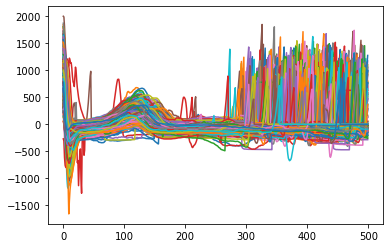

In [20]:
plot_sig(data1_new)  # the orginal data
# plot_sig(data1_st)  # the normalized data

In [21]:
# plot_sig(data2_new)
# plot_sig(data2_st)

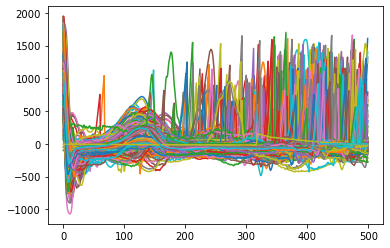

In [22]:
plot_sig(data3_new)
# plot_sig(data3_st)

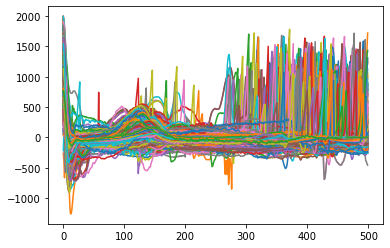

In [23]:
plot_sig(data4_new)
# plot_sig(data4_st)

In [24]:
# plot_sig(data5_new)
# plot_sig(data5_st)

# Extracting features

In [25]:
import pywt
from scipy.fftpack import fft

def extract_dwt(arr):        # DWT
    f = []
    for i in range(arr.shape[0]):
        cA, cD = pywt.dwt(arr[i, :], 'db1')
        f.append(np.concatenate([cA, cD]))

    return np.stack(f)

def extract_fft(arr):         # FFT
    f = []
    for i in range(arr.shape[0]):
        
        fft_y = fft(arr[i, :])
        fft_y1 = np.abs(fft_y)/len(arr[i, :])
        fft_y2 = fft_y1[range(int(len(arr[i, :])/2))]
        f.append(fft_y2)

    return np.stack(f)
    
def extract_13f(arr):     # Statistic features
    f = []
    for i in range(len(arr)):
        feature_extracted = []

        t = arr[i, :]
#         t = arr[i]
        feature_extracted.append(t.mean())
        feature_extracted.append(np.median(t))
        feature_extracted.append(t.std())
        feature_extracted.append(t.max())
        feature_extracted.append(t.min())
        feature_extracted.append(np.sqrt(t.dot(t)/t.size))
        
        t = pd.Series(arr[i, :])
#         t = pd.Series(arr[i])
        q1, q3 = t.quantile(.25), t.quantile(.75)
        iqr = q3 - q1
        feature_extracted.extend([q1, q3, iqr, t.skew(), t.kurt()])
        
        f.append(feature_extracted)

    return np.array(f)

from scipy.fftpack import fft, ifft

def c0_complexity(data):   # C0 complexity
    N = len(data)
    vxf = fft(data)
    magvxf = np.abs(vxf)**2
    vxmean = np.mean(magvxf)
    
    for i in range(N):
        if (magvxf[i] <= 10*vxmean):
            vxf[i]=0

    vx1 = ifft(vxf)

    sum1 = 0
    SUM1 = 0
    vx2 = np.zeros(N)
    for j in range(N):
        vx2[j] = (data[j]-vx1[j])**2
        sum1 = sum1 + vx2[j]
        SUM1 = SUM1 + data[j]**2

    c01 = sum1/SUM1

    return c01

from entropy import *
import warnings
warnings.filterwarnings("ignore")

def entropies(data):       # Entropy & Fractal dimension
    entropy = np.zeros(9)

    try:
        entropy[0] = perm_entropy(data, order=3, normalize=True)
    except:
        print('perm error')
        entropy[0] = np.nan
    
    try:
        entropy[1] = spectral_entropy(data, 100, method='welch', normalize=True)
    except:
        print('spec error')
        entropy[1] = np.nan
    
    try:
        entropy[2] = svd_entropy(data, order=3, delay=1, normalize=True) 
    except:
        print('svd error')
        entropy[2] = np.nan
    
    try:
        entropy[3] = app_entropy(data, order=2, metric='chebyshev') 
    except:
        print('app error')
        entropy[3] = np.nan

    try:
        entropy[4] = sample_entropy(data, order=2, metric='chebyshev')
    except:
        print('samp error')
        entropy[4] = np.nan
    
    try:
        entropy[5] = petrosian_fd(data)
    except:
        print('petr error')
        entropy[5] = np.nan
    
    try:
        entropy[6] = katz_fd(data)
    except:
        print('katz error')
        entropy[6] = np.nan
    
    try:
        entropy[7] = higuchi_fd(data, kmax=10)
    except:
        print('higu error')
        entropy[7] = np.nan

    try:
        entropy[8] = detrended_fluctuation(data)
    except:
        print('detr error')
        entropy[8] = np.nan

    return entropy.reshape((1,-1))

In [ ]:
data = np.load('data_all.npy')
data = data[:, :-1]

data_c0 = []
for i in range(data.shape[0]):
    data_c0.append(c0_complexity(data[i, :]))
data_c0 = np.array(data_c0).reshape((-1,1))

data_en = []
for i in range(data.shape[0]):
    data_en.append(entropies(data[i, :]))
data_en = np.concatenate(data_en, axis=0)

data_dwt = extract_dwt(data)
data_fft = extract_fft(data)
data_other = extract_13f(data)

In [26]:
# Functional data analysis 

import skfda

four = []
for i in range(data.shape[0]):
    grid_points = range(data.shape[1])  # Grid points of the curves
    data_matrix = data[i, :]

    fd = skfda.FDataGrid(
        data_matrix=data_matrix,
        grid_points=grid_points,
    )

    basis = skfda.representation.basis.Fourier(n_basis=500)
    basis_fd = fd.to_basis(basis)
    
    four.append(basis_fd.coefficients[0])
data_four = np.stack(four)

bsp = []
for i in range(data.shape[0]):
    grid_points = range(data.shape[1])  # Grid points of the curves
    data_matrix = data[i, :]

    fd = skfda.FDataGrid(
        data_matrix=data_matrix,
        grid_points=grid_points,
    )

    basis = skfda.representation.basis.BSpline(n_basis=500, order=4)
    basis_fd = fd.to_basis(basis)
    
    bsp.append(basis_fd.coefficients[0])
data_bsp = np.stack(bsp)

In [27]:
np.save('data_dwt.npy', data_dwt)
np.save('data_fft.npy', data_fft)
np.save('data_other.npy', data_other)
np.save('data_c0.npy', data_c0)
np.save('data_en.npy', data_en)
np.save('data_bsp.npy', data_bsp)
np.save('data_four.npy', data_four)

### Using Tsfresh to extract features & classify

In [28]:
data = np.load('data_all.npy')
y = data[:, -1]
data = data[:, :-1]

data_ts = []
for i in range(data.shape[0]):
    data_ts.append(np.concatenate((np.full((data.shape[1], 1), i), np.array(range(data.shape[1])).reshape((-1,1)), data[i, :].reshape((-1,1))), axis=1))

df_ts = pd.DataFrame(np.concatenate(data_ts, axis=0))
df_ts.columns = ['id','time','x']
df_ts    

id   time       x
0           0.0    0.0  572.90
1           0.0    1.0  455.40
2           0.0    2.0  298.55
3           0.0    3.0  148.10
4           0.0    4.0    3.35
...         ...    ...     ...
2321995  4643.0  495.0    0.00
2321996  4643.0  496.0    0.00
2321997  4643.0  497.0    0.00
2321998  4643.0  498.0    0.00
2321999  4643.0  499.0    0.00

[2322000 rows x 3 columns]

In [38]:
from tsfresh import extract_relevant_features

features_filtered_direct = extract_relevant_features(df_ts, pd.Series(y),
                                                     column_id='id', column_sort='time')

Feature Extraction: 100%|█████████████████████████████████████████████████████████████| 10/10 [20:00<00:00, 120.05s/it]


In [39]:
features_filtered_direct

x__permutation_entropy__dimension_7__tau_1  x__number_peaks__n_1  \
0.0                                       2.022893                  16.0   
1.0                                       4.412762                  50.0   
2.0                                       3.649575                  16.0   
3.0                                       2.359595                   8.0   
4.0                                       2.931945                  19.0   
...                                            ...                   ...   
4639.0                                    4.811266                  83.0   
4640.0                                    4.835353                  97.0   
4641.0                                    5.543891                 115.0   
4642.0                                    5.653588                 114.0   
4643.0                                    5.618192                 102.0   

        x__number_peaks__n_3  x__ratio_value_number_to_time_series_length  \
0.0                      5.0                                        0.402   
1.0                     20.0                                        0.864   
2.0                      8.0                                        0.656   
3.0                      5.0                                        0.588   
4.0                      6.0                                        0.554   
...                      ...                                          ...   
4639.0                  41.0                                        0.758   
4640.0                  29.0                                        0.864   
4641.0                  43.0                                        0.996   
4642.0                  41.0                                        0.988   
4643.0                  50.0                                        0.932   

        x__sum_of_reoccurring_data_points  x__sum_of_reoccurring_values  \
0.0                              -6396.15                      -2222.15   
1.0                               3750.00                       1789.75   
2.0                             -13480.55                      -3617.75   
3.0                              -4199.95                       -631.30   
4.0                             -11090.60                      -2931.35   
...                                   ...                           ...   
4639.0                               0.00                          0.00   
4640.0                               0.00                          0.00   
4641.0                               0.00                          0.00   
4642.0                               0.00                          0.00   
4643.0                               0.00                          0.00   

        x__percentage_of_reoccurring_datapoints_to_all_datapoints  \
0.0                                                 0.662           
1.0                                                 0.248           
2.0                                                 0.504           
3.0                                                 0.502           
4.0                                                 0.542           
...                                                   ...           
4639.0                                              0.244           
4640.0                                              0.138           
4641.0                                              0.006           
4642.0                                              0.014           
4643.0                                              0.070           

        x__percentage_of_reoccurring_values_to_all_values  \
0.0                                              0.159204   
1.0                                              0.129630   
2.0                                              0.243902   
3.0                                              0.153061   
4.0                                              0.173285   
...                                                   ...   
4639.0       

In [40]:
np.save('data_ts.npy', features_filtered_direct.values)

Arrhythmia

Ischemia

Arrhythmia & Ischemia

Feature analysis

# Classification

In [46]:
# load extracted features
from sklearn.model_selection import train_test_split
from sklearn.decomposition import FastICA
from xgboost import XGBClassifier
from sklearn.metrics import classification_report,plot_confusion_matrix
from lightgbm import LGBMClassifier

data_dwt = np.load('data_dwt.npy')
data_fft = np.load('data_fft.npy')
data_other = np.load('data_other.npy')
data_c0 = np.load('data_c0.npy')
data_en = np.load('data_en.npy')
data_bsp = np.load('data_bsp.npy')
data_four = np.load('data_four.npy')
features_filtered_direct = np.load('data_ts.npy')

In [47]:
data = np.load('data_all.npy')
data = pd.DataFrame(data)
data.iloc[:,-1].value_counts()

0.0    1771
2.0    1743
1.0    1130
Name: 500, dtype: int64

## Arrhythmia
### FFT

              precision    recall  f1-score   support

         0.0       0.74      0.85      0.79       355
         1.0       0.69      0.52      0.59       226

    accuracy                           0.72       581
   macro avg       0.71      0.69      0.69       581
weighted avg       0.72      0.72      0.71       581



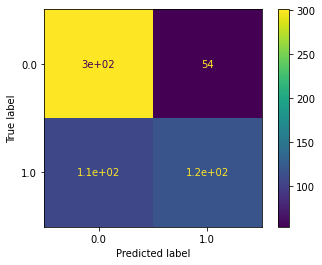

In [48]:
data_all = np.concatenate([data_fft], axis=1)
data_all = pd.DataFrame(data_all)

data = np.load('data_all.npy')
data = pd.DataFrame(data)
data_all = pd.concat([data_all, data.iloc[:, -1]], axis=1)
data = data_all.loc[data_all.iloc[:,-1].isin([0,1]), :]
X_train, X_test, y_train, y_test = train_test_split(data.iloc[:, :-1].values, data.iloc[:, -1].values, random_state=42, stratify=data.iloc[:, -1].values, test_size=0.2)

# create classifer with sampel weight and gpu accelerating
# XGB = XGBClassifier(tree_method='gpu_hist', gpu_id=0, objective='binary:logistic', n_estimators=1)
XGB = LGBMClassifier( boosting_type='gbdt', \
                            objective='binary', \
                            metric='binary_logloss', \
                            num_leaves=31, \
                            n_estimators=100, \
                            learning_rate=0.1, \
                            feature_fraction=0.8, \
                            bagging_fraction=0.8, \
                            bagging_freq=10)
# training step
XGB.fit(X_train, y_train)
# predict test data
result_XGB = XGB.predict(X_test)
# XGB.save_model('./XGB_Classification_weightedsss.json')
# print ACC, RECALL, PRECISION
print(classification_report(y_test, result_XGB, zero_division = 0))

# confusiong matrix plotting
con_fus = plot_confusion_matrix(XGB, X_test, y_test)
plt.show()

### DWT

              precision    recall  f1-score   support

         0.0       0.97      0.93      0.95       355
         1.0       0.90      0.96      0.93       226

    accuracy                           0.94       581
   macro avg       0.94      0.95      0.94       581
weighted avg       0.95      0.94      0.94       581



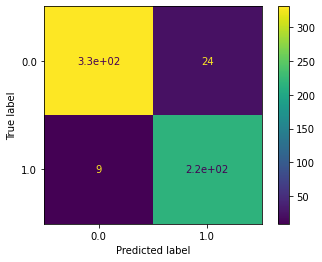

In [49]:
data_all = np.concatenate([data_dwt], axis=1)
data_all = pd.DataFrame(data_all)

data = np.load('data_all.npy')
data = pd.DataFrame(data)
data_all = pd.concat([data_all, data.iloc[:, -1]], axis=1)
data = data_all.loc[data_all.iloc[:,-1].isin([0,1]), :]
X_train, X_test, y_train, y_test = train_test_split(data.iloc[:, :-1].values, data.iloc[:, -1].values, random_state=42, stratify=data.iloc[:, -1].values, test_size=0.2)

# create classifer with sampel weight and gpu accelerating
# XGB = XGBClassifier(tree_method='gpu_hist', gpu_id=0, objective='binary:logistic', n_estimators=1)
XGB = LGBMClassifier( boosting_type='gbdt', \
                            objective='binary', \
                            metric='binary_logloss', \
                            num_leaves=31, \
                            n_estimators=100, \
                            learning_rate=0.1, \
                            feature_fraction=0.8, \
                            bagging_fraction=0.8, \
                            bagging_freq=10)
# training step
XGB.fit(X_train, y_train)
# predict test data
result_XGB = XGB.predict(X_test)
# XGB.save_model('./XGB_Classification_weightedsss.json')
# print ACC, RECALL, PRECISION
print(classification_report(y_test, result_XGB, zero_division = 0))

# confusiong matrix plotting
con_fus = plot_confusion_matrix(XGB, X_test, y_test)
plt.show()

### FDA

              precision    recall  f1-score   support

         0.0       0.83      0.91      0.87       355
         1.0       0.84      0.70      0.76       226

    accuracy                           0.83       581
   macro avg       0.83      0.81      0.82       581
weighted avg       0.83      0.83      0.83       581



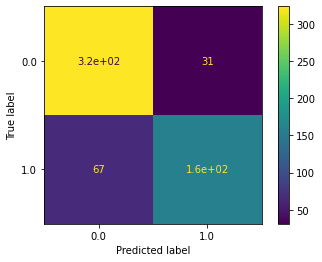

In [60]:
data_all = np.concatenate([data_bsp], axis=1)
data_all = pd.DataFrame(data_all)

data = np.load('data_all.npy')
data = pd.DataFrame(data)
data_all = pd.concat([data_all, data.iloc[:, -1]], axis=1)
data = data_all.loc[data_all.iloc[:,-1].isin([0,1]), :]
X_train, X_test, y_train, y_test = train_test_split(data.iloc[:, :-1].values, data.iloc[:, -1].values, random_state=42, stratify=data.iloc[:, -1].values, test_size=0.2)

# create classifer with sampel weight and gpu accelerating
# XGB = XGBClassifier(tree_method='gpu_hist', gpu_id=0, objective='binary:logistic', n_estimators=1)
XGB = LGBMClassifier( boosting_type='gbdt', \
                            objective='binary', \
                            metric='binary_logloss', \
                            num_leaves=31, \
                            n_estimators=100, \
                            learning_rate=0.1, \
                            feature_fraction=0.8, \
                            bagging_fraction=0.8, \
                            bagging_freq=10)
# training step
XGB.fit(X_train, y_train)
# predict test data
result_XGB = XGB.predict(X_test)
# XGB.save_model('./XGB_Classification_weightedsss.json')
# print ACC, RECALL, PRECISION
print(classification_report(y_test, result_XGB, zero_division = 0))

# confusiong matrix plotting
con_fus = plot_confusion_matrix(XGB, X_test, y_test)
plt.show()

### Statistical features

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99       355
         1.0       0.98      0.99      0.98       226

    accuracy                           0.99       581
   macro avg       0.99      0.99      0.99       581
weighted avg       0.99      0.99      0.99       581



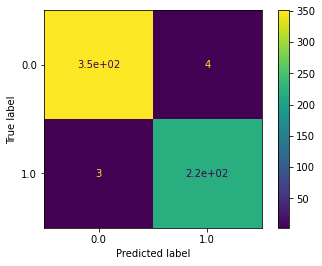

In [50]:
data_all = np.concatenate([data_other, data_c0, data_en], axis=1)
data_all = pd.DataFrame(data_all)

data = np.load('data_all.npy')
data = pd.DataFrame(data)
data_all = pd.concat([data_all, data.iloc[:, -1]], axis=1)
data = data_all.loc[data_all.iloc[:,-1].isin([0,1]), :]
X_train, X_test, y_train, y_test = train_test_split(data.iloc[:, :-1].values, data.iloc[:, -1].values, random_state=42, stratify=data.iloc[:, -1].values, test_size=0.2)

# create classifer with sampel weight and gpu accelerating
# XGB = XGBClassifier(tree_method='gpu_hist', gpu_id=0, objective='binary:logistic', n_estimators=1)
XGB = LGBMClassifier( boosting_type='gbdt', \
                            objective='binary', \
                            metric='binary_logloss', \
                            num_leaves=31, \
                            n_estimators=100, \
                            learning_rate=0.1, \
                            feature_fraction=0.8, \
                            bagging_fraction=0.8, \
                            bagging_freq=10)
# training step
XGB.fit(X_train, y_train)
# predict test data
result_XGB = XGB.predict(X_test)
# XGB.save_model('./XGB_Classification_weightedsss.json')
# print ACC, RECALL, PRECISION
print(classification_report(y_test, result_XGB, zero_division = 0))

# confusiong matrix plotting
con_fus = plot_confusion_matrix(XGB, X_test, y_test)
plt.show()

In [51]:
fi = pd.DataFrame(XGB.feature_importances_, columns=['Scores'], index=['mean', 'median', 'std', 'max', 'min', 'rms', 'q1', 'q3', 'iqr', 'skew', 'kurt', 'c0','perm','spec','svd','app','samp','petr','katz','higu','detr'])
fi.sort_values(by='Scores', ascending=False)

Scores
petr       562
perm       363
spec       232
min        164
app        150
median     148
higu       133
mean       126
svd        122
samp       120
katz       119
detr       106
max         92
q1          88
iqr         87
skew        77
q3          74
c0          73
kurt        60
rms         49
std         43

## Ischemia
### FFT

              precision    recall  f1-score   support

         0.0       0.74      0.77      0.75       354
         2.0       0.76      0.73      0.74       349

    accuracy                           0.75       703
   macro avg       0.75      0.75      0.75       703
weighted avg       0.75      0.75      0.75       703



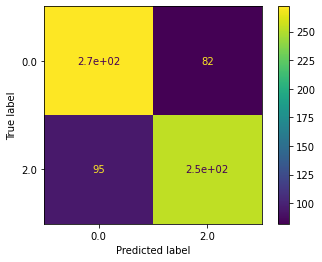

In [52]:
data_all = np.concatenate([data_fft], axis=1)
data_all = pd.DataFrame(data_all)

data = np.load('data_all.npy')
data = pd.DataFrame(data)
data_all = pd.concat([data_all, data.iloc[:, -1]], axis=1)
data = data_all.loc[data_all.iloc[:,-1].isin([0,2]), :]
X_train, X_test, y_train, y_test = train_test_split(data.iloc[:, :-1].values, data.iloc[:, -1].values, random_state=42, stratify=data.iloc[:, -1].values, test_size=0.2)

# create classifer with sampel weight and gpu accelerating
# XGB = XGBClassifier(tree_method='gpu_hist', gpu_id=0, objective='binary:logistic', n_estimators=1)
XGB = LGBMClassifier( boosting_type='gbdt', \
                            objective='binary', \
                            metric='binary_logloss', \
                            num_leaves=31, \
                            n_estimators=100, \
                            learning_rate=0.1, \
                            feature_fraction=0.8, \
                            bagging_fraction=0.8, \
                            bagging_freq=10)
# training step
XGB.fit(X_train, y_train)
# predict test data
result_XGB = XGB.predict(X_test)
# XGB.save_model('./XGB_Classification_weightedsss.json')
# print ACC, RECALL, PRECISION
print(classification_report(y_test, result_XGB, zero_division = 0))

# confusiong matrix plotting
con_fus = plot_confusion_matrix(XGB, X_test, y_test)
plt.show()

### DWT

              precision    recall  f1-score   support

         0.0       0.97      0.92      0.94       354
         2.0       0.92      0.97      0.95       349

    accuracy                           0.94       703
   macro avg       0.95      0.94      0.94       703
weighted avg       0.95      0.94      0.94       703



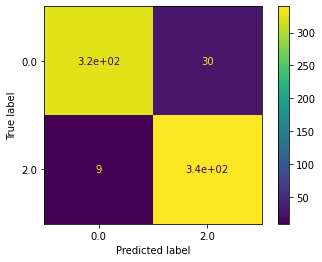

In [53]:
data_all = np.concatenate([data_dwt], axis=1)
data_all = pd.DataFrame(data_all)

data = np.load('data_all.npy')
data = pd.DataFrame(data)
data_all = pd.concat([data_all, data.iloc[:, -1]], axis=1)
data = data_all.loc[data_all.iloc[:,-1].isin([0,2]), :]
X_train, X_test, y_train, y_test = train_test_split(data.iloc[:, :-1].values, data.iloc[:, -1].values, random_state=42, stratify=data.iloc[:, -1].values, test_size=0.2)

# create classifer with sampel weight and gpu accelerating
# XGB = XGBClassifier(tree_method='gpu_hist', gpu_id=0, objective='binary:logistic', n_estimators=1)
XGB = LGBMClassifier( boosting_type='gbdt', \
                            objective='binary', \
                            metric='binary_logloss', \
                            num_leaves=31, \
                            n_estimators=100, \
                            learning_rate=0.1, \
                            feature_fraction=0.8, \
                            bagging_fraction=0.8, \
                            bagging_freq=10)
# training step
XGB.fit(X_train, y_train)
# predict test data
result_XGB = XGB.predict(X_test)
# XGB.save_model('./XGB_Classification_weightedsss.json')
# print ACC, RECALL, PRECISION
print(classification_report(y_test, result_XGB, zero_division = 0))

# confusiong matrix plotting
con_fus = plot_confusion_matrix(XGB, X_test, y_test)
plt.show()

### FDA

              precision    recall  f1-score   support

         0.0       0.80      0.85      0.82       354
         2.0       0.84      0.79      0.81       349

    accuracy                           0.82       703
   macro avg       0.82      0.82      0.82       703
weighted avg       0.82      0.82      0.82       703



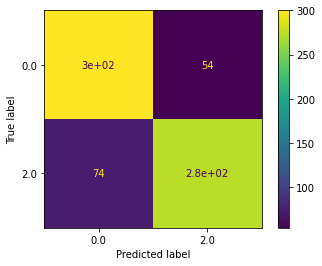

In [61]:
data_all = np.concatenate([data_bsp], axis=1)
data_all = pd.DataFrame(data_all)

data = np.load('data_all.npy')
data = pd.DataFrame(data)
data_all = pd.concat([data_all, data.iloc[:, -1]], axis=1)
data = data_all.loc[data_all.iloc[:,-1].isin([0,2]), :]
X_train, X_test, y_train, y_test = train_test_split(data.iloc[:, :-1].values, data.iloc[:, -1].values, random_state=42, stratify=data.iloc[:, -1].values, test_size=0.2)

# create classifer with sampel weight and gpu accelerating
# XGB = XGBClassifier(tree_method='gpu_hist', gpu_id=0, objective='binary:logistic', n_estimators=1)
XGB = LGBMClassifier( boosting_type='gbdt', \
                            objective='binary', \
                            metric='binary_logloss', \
                            num_leaves=31, \
                            n_estimators=100, \
                            learning_rate=0.1, \
                            feature_fraction=0.8, \
                            bagging_fraction=0.8, \
                            bagging_freq=10)

# training step
XGB.fit(X_train, y_train)
# predict test data
result_XGB = XGB.predict(X_test)
# XGB.save_model('./XGB_Classification_weightedsss.json')
# print ACC, RECALL, PRECISION
print(classification_report(y_test, result_XGB, zero_division = 0))

# confusiong matrix plotting
con_fus = plot_confusion_matrix(XGB, X_test, y_test)
plt.show()

### Statistical features

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99       354
         2.0       0.99      0.99      0.99       349

    accuracy                           0.99       703
   macro avg       0.99      0.99      0.99       703
weighted avg       0.99      0.99      0.99       703



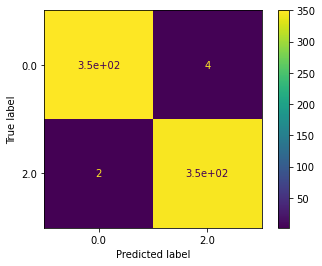

In [54]:
data_all = np.concatenate([data_other, data_c0, data_en], axis=1)
data_all = pd.DataFrame(data_all)

data = np.load('data_all.npy')
data = pd.DataFrame(data)
data_all = pd.concat([data_all, data.iloc[:, -1]], axis=1)
data = data_all.loc[data_all.iloc[:,-1].isin([0,2]), :]
X_train, X_test, y_train, y_test = train_test_split(data.iloc[:, :-1].values, data.iloc[:, -1].values, random_state=42, stratify=data.iloc[:, -1].values, test_size=0.2)

# create classifer with sampel weight and gpu accelerating
# XGB = XGBClassifier(tree_method='gpu_hist', gpu_id=0, objective='binary:logistic', n_estimators=1)
XGB = LGBMClassifier( boosting_type='gbdt', \
                            objective='binary', \
                            metric='binary_logloss', \
                            num_leaves=31, \
                            n_estimators=100, \
                            learning_rate=0.1, \
                            feature_fraction=0.8, \
                            bagging_fraction=0.8, \
                            bagging_freq=10)

# training step
XGB.fit(X_train, y_train)
# predict test data
result_XGB = XGB.predict(X_test)
# XGB.save_model('./XGB_Classification_weightedsss.json')
# print ACC, RECALL, PRECISION
print(classification_report(y_test, result_XGB, zero_division = 0))

# confusiong matrix plotting
con_fus = plot_confusion_matrix(XGB, X_test, y_test)
plt.show()

In [55]:
fi = pd.DataFrame(XGB.feature_importances_, columns=['Scores'], index=['mean', 'median', 'std', 'max', 'min', 'rms', 'q1', 'q3', 'iqr', 'skew', 'kurt', 'c0','perm','spec','svd','app','samp','petr','katz','higu','detr'])
fi.sort_values(by='Scores', ascending=False)

Scores
petr       545
perm       322
min        199
spec       191
median     162
samp       157
higu       150
svd        146
detr       133
app        116
iqr        113
katz       106
q1          97
mean        83
max         83
c0          70
kurt        67
skew        65
q3          63
std         62
rms         57

## Covid_19

In [ ]:
# data_all = np.concatenate([data_other, data_c0, data_en], axis=1)
# data_all = pd.DataFrame(data_all)

# data = np.load('data_all.npy')
# data = pd.DataFrame(data)
# data_all = pd.concat([data_all, data.iloc[:, -1]], axis=1)
# data = data_all.loc[data_all.iloc[:,-1].isin([0,3]), :]
# X_train, X_test, y_train, y_test = train_test_split(data.iloc[:, :-1].values, data.iloc[:, -1].values, random_state=42, stratify=data.iloc[:, -1].values, test_size=0.2)

# # create classifer with sampel weight and gpu accelerating
# XGB = XGBClassifier(tree_method='gpu_hist', gpu_id=0, objective='binary:logistic', n_estimators=1)
# # XGB = LGBMClassifier( boosting_type='gbdt', \
# #                             objective='binary', \
# #                             metric='binary_logloss', \
# #                             num_leaves=15, \
# #                             n_estimators=100, \
# #                             learning_rate=0.1, \
# #                             feature_fraction=0.8, \
# #                             bagging_fraction=0.8, \
# #                             bagging_freq=10)
# # training step
# XGB.fit(X_train, y_train)
# # predict test data
# result_XGB = XGB.predict(X_test)
# # XGB.save_model('./XGB_Classification_weightedsss.json')
# # print ACC, RECALL, PRECISION
# print(classification_report(y_test, result_XGB, zero_division = 0))

# # confusiong matrix plotting
# con_fus = plot_confusion_matrix(XGB, X_test, y_test)
# plt.show()

## Arrhythmia & Ischemia
### FFT

              precision    recall  f1-score   support

         0.0       0.61      0.69      0.65       354
         1.0       0.50      0.29      0.37       226
         2.0       0.55      0.62      0.58       349

    accuracy                           0.57       929
   macro avg       0.55      0.54      0.53       929
weighted avg       0.56      0.57      0.56       929



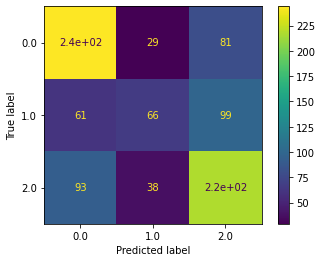

In [56]:
data_all = np.concatenate([data_fft], axis=1)
data_all = pd.DataFrame(data_all)

data = np.load('data_all.npy')
data = pd.DataFrame(data)
data_all = pd.concat([data_all, data.iloc[:, -1]], axis=1)
data = data_all.loc[data_all.iloc[:,-1].isin([0,1,2]), :]
X_train, X_test, y_train, y_test = train_test_split(data.iloc[:, :-1].values, data.iloc[:, -1].values, random_state=42, stratify=data.iloc[:, -1].values, test_size=0.2)

# create classifer with sampel weight and gpu accelerating
# XGB = XGBClassifier(tree_method='gpu_hist', gpu_id=0, objective='binary:logistic', n_estimators=1)
XGB = LGBMClassifier( boosting_type='gbdt', \
                            objective='multiclass', \
                            metric='multi_logloss', \
                            num_leaves=31, \
                            n_estimators=100, \
                            learning_rate=0.1, \
                            feature_fraction=0.8, \
                            bagging_fraction=0.8, \
                            bagging_freq=10)
# training step
XGB.fit(X_train, y_train)
# predict test data
result_XGB = XGB.predict(X_test)
# XGB.save_model('./XGB_Classification_weightedsss.json')
# print ACC, RECALL, PRECISION
print(classification_report(y_test, result_XGB, zero_division = 0))

# confusiong matrix plotting
con_fus = plot_confusion_matrix(XGB, X_test, y_test)
plt.show()

### DWT

              precision    recall  f1-score   support

         0.0       0.94      0.92      0.93       354
         1.0       0.57      0.35      0.44       226
         2.0       0.66      0.84      0.74       349

    accuracy                           0.75       929
   macro avg       0.72      0.70      0.70       929
weighted avg       0.75      0.75      0.74       929



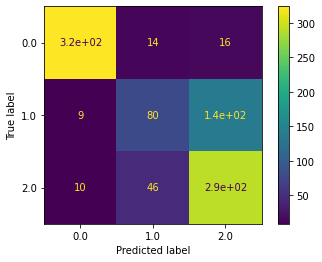

In [57]:
data_all = np.concatenate([data_dwt], axis=1)
data_all = pd.DataFrame(data_all)

data = np.load('data_all.npy')
data = pd.DataFrame(data)
data_all = pd.concat([data_all, data.iloc[:, -1]], axis=1)
data = data_all.loc[data_all.iloc[:,-1].isin([0,1,2]), :]
X_train, X_test, y_train, y_test = train_test_split(data.iloc[:, :-1].values, data.iloc[:, -1].values, random_state=42, stratify=data.iloc[:, -1].values, test_size=0.2)

# create classifer with sampel weight and gpu accelerating
# XGB = XGBClassifier(tree_method='gpu_hist', gpu_id=0, objective='binary:logistic', n_estimators=1)
XGB = LGBMClassifier( boosting_type='gbdt', \
                            objective='multiclass', \
                            metric='multi_logloss', \
                            num_leaves=31, \
                            n_estimators=100, \
                            learning_rate=0.1, \
                            feature_fraction=0.8, \
                            bagging_fraction=0.8, \
                            bagging_freq=10)
# training step
XGB.fit(X_train, y_train)
# predict test data
result_XGB = XGB.predict(X_test)
# XGB.save_model('./XGB_Classification_weightedsss.json')
# print ACC, RECALL, PRECISION
print(classification_report(y_test, result_XGB, zero_division = 0))

# confusiong matrix plotting
con_fus = plot_confusion_matrix(XGB, X_test, y_test)
plt.show()

### FDA

              precision    recall  f1-score   support

         0.0       0.74      0.83      0.78       354
         1.0       0.67      0.44      0.53       226
         2.0       0.66      0.73      0.69       349

    accuracy                           0.70       929
   macro avg       0.69      0.67      0.67       929
weighted avg       0.69      0.70      0.69       929



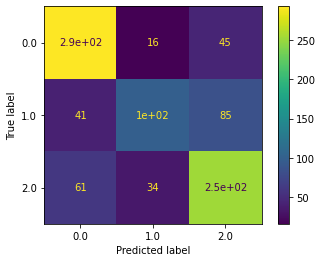

In [62]:
data_all = np.concatenate([data_bsp], axis=1)
data_all = pd.DataFrame(data_all)

data = np.load('data_all.npy')
data = pd.DataFrame(data)
data_all = pd.concat([data_all, data.iloc[:, -1]], axis=1)
data = data_all.loc[data_all.iloc[:,-1].isin([0,1,2]), :]
X_train, X_test, y_train, y_test = train_test_split(data.iloc[:, :-1].values, data.iloc[:, -1].values, random_state=42, stratify=data.iloc[:, -1].values, test_size=0.2)

# create classifer with sampel weight and gpu accelerating
from lightgbm import LGBMClassifier

# XGB = XGBClassifier(tree_method='gpu_hist', gpu_id=0, objective='multi:softmax', n_estimators=10)
XGB = LGBMClassifier( boosting_type='gbdt',
                        objective='multiclass',
                        num_class=3,
                        metric='multi_logloss',
                        num_leaves=31,
                        max_depth=15,
                        n_estimators=500,
                        learning_rate=0.1,
                        feature_fraction=0.7,
                        bagging_fraction=0.7,
                        bagging_freq=10)

# training step
# XGB.fit(X_train, y_train, sample_weight = sampleW)
XGB.fit(X_train, y_train)
# predict test data
result_XGB = XGB.predict(X_test)
#XGB.save_model('./XGB_Classification_weightedsss.json')
# print ACC, RECALL, PRECISION
print(classification_report(y_test, result_XGB, zero_division = 0))

# confusiong matrix plotting
con_fus = plot_confusion_matrix(XGB, X_test, y_test)
plt.show()

### Statistical features

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99       354
         1.0       0.73      0.62      0.67       226
         2.0       0.78      0.85      0.81       349

    accuracy                           0.85       929
   macro avg       0.83      0.82      0.82       929
weighted avg       0.85      0.85      0.84       929



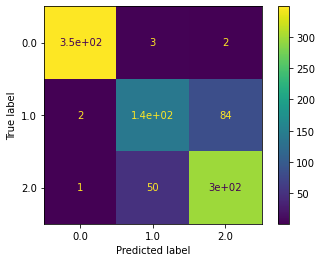

In [63]:
data_all = np.concatenate([data_other, data_c0, data_en], axis=1)
data_all = pd.DataFrame(data_all)

data = np.load('data_all.npy')
data = pd.DataFrame(data)
data_all = pd.concat([data_all, data.iloc[:, -1]], axis=1)
data = data_all.loc[data_all.iloc[:,-1].isin([0,1,2]), :]
X_train, X_test, y_train, y_test = train_test_split(data.iloc[:, :-1].values, data.iloc[:, -1].values, random_state=42, stratify=data.iloc[:, -1].values, test_size=0.2)

# create classifer with sampel weight and gpu accelerating
from lightgbm import LGBMClassifier

# XGB = XGBClassifier(tree_method='gpu_hist', gpu_id=0, objective='multi:softmax', n_estimators=10)
XGB = LGBMClassifier( boosting_type='gbdt',
                        objective='multiclass',
                        num_class=3,
                        metric='multi_logloss',
                        num_leaves=31,
                        max_depth=15,
                        n_estimators=500,
                        learning_rate=0.1,
                        feature_fraction=0.7,
                        bagging_fraction=0.7,
                        bagging_freq=10)

# training step
# XGB.fit(X_train, y_train, sample_weight = sampleW)
XGB.fit(X_train, y_train)
# predict test data
result_XGB = XGB.predict(X_test)
#XGB.save_model('./XGB_Classification_weightedsss.json')
# print ACC, RECALL, PRECISION
print(classification_report(y_test, result_XGB, zero_division = 0))

# confusiong matrix plotting
con_fus = plot_confusion_matrix(XGB, X_test, y_test)
plt.show()

In [64]:
fi = pd.DataFrame(XGB.feature_importances_, columns=['Scores'], index=['mean', 'median', 'std', 'max', 'min', 'rms', 'q1', 'q3', 'iqr', 'skew', 'kurt', 'c0','perm','spec','svd','app','samp','petr','katz','higu','detr'])
fi.sort_values(by='Scores', ascending=False)

Scores
petr      3094
min       2589
perm      2518
spec      2515
higu      2443
katz      2248
max       2244
detr      2151
samp      2083
svd       2069
app       1915
c0        1899
mean      1892
skew      1885
iqr       1825
kurt      1777
median    1681
std       1595
q1        1473
rms       1318
q3        1076

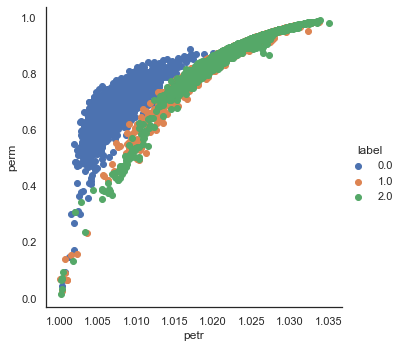

In [65]:
import seaborn as sns

data_all = np.concatenate([data_other, data_c0, data_en], axis=1)
data_all = pd.DataFrame(data_all)
data_all.columns = ['mean', 'median', 'std', 'max', 'min', 'rms', 'q1', 'q3', 'iqr', 'skew', 'kurt','c0','perm','spec','svd','app','samp','petr','katz','higu','detr']

data = np.load('data_all.npy')
data = pd.DataFrame(data)
data_all = pd.concat([data_all, data.iloc[:, -1]], axis=1)

DF = data_all
DF.columns = ['mean', 'median', 'std', 'max', 'min', 'rms', 'q1', 'q3', 'iqr', 'skew', 'kurt','c0','perm','spec','svd','app','samp','petr','katz','higu','detr','label']

sns.set(style="white", color_codes=True)
sns.FacetGrid(DF, hue="label", size=5) \
   .map(plt.scatter, "petr", "perm") \
   .add_legend()

# Feature Analysis

In [66]:
import plotly.graph_objects as ply_go

my_title_layout = dict({"text":"my distribution", 'xanchor':'center', 'x':0.5, 'y':0.9, 'font':{'size':24}})
my_xaxis_layout = dict(title=dict(text="my x axis", font={'size':16}))
my_layout = dict(title=my_title_layout,
                xaxis= my_xaxis_layout)

for c in ['petr','perm','spec','min','max','samp','detr','c0','katz','svd']:
    fig = ply_go.Figure(layout = my_layout)
    # for tmp_diag in DF['covid_status'].unique():
    for tmp_diag, tmp_name in enumerate(['healthy', 'arrythmia', 'ischemia']):

        violin_data = ply_go.Violin(x=DF.loc[DF['label']==tmp_diag, 'label'],
                                    y=DF.loc[DF['label']==tmp_diag, c],
                                    name=tmp_name,
                                    box_visible=True,
                                    meanline_visible=True)
        fig.add_trace(violin_data)

    fig.update_layout(title={'text': c}, xaxis={"title":{"text":None}}, 
                    yaxis={"title":{"text":c}})
    fig.show()